# PBMC datasets - vary size of query dataset for simulations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import scipy
import anndata

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import q2r_uncertainty
import diff2atlas


ModuleNotFoundError: No module named 'q2r_uncertainty'

In [ ]:
import celltypist
import milopy

In [ ]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import anndata2ri
anndata2ri.activate()

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(tidyverse)
library(patchwork)

In [ ]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

### Split query batch with variable no of cells

In [5]:
query_dataset = '10_1038_s41591_021_01329_2'

### Map to model trained on 500 cells per sample

Built in [here](https://github.com/emdann/query2reference_uncertainty/blob/master/notebooks/PBMC_metanalysis/20220531_PBMC_metadata.ipynb)

In [12]:
data_dir = '/home/jovyan/mount/gdrive/query2reference/PBMC_CZIintegration_data/'
model_path = data_dir + 'PBMC_merged.normal.subsample500cells_model'
# adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.scVI.h5ad')

### Concatenate with atlas data

In [ ]:
ad

## Cluster

In [ ]:
%%time
sc.tl.leiden(adata, resolution=1.5, neighbors_key='scVI', n_iterations=5)

CPU times: user 7min 55s, sys: 11.1 s, total: 8min 6s
Wall time: 8min 5s


In [ ]:
# adata.write_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.scVI.h5ad')

In [ ]:
# adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.scVI.h5ad', backed=True)

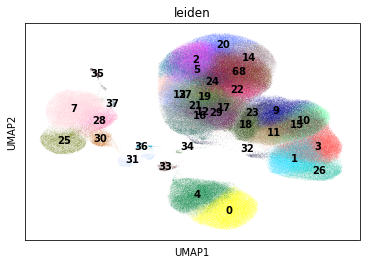

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')

In [ ]:
conf_mat = sc.metrics.confusion_matrix('leiden', 'cell_type', adata.obs)

In [ ]:
cell_type_leiden = dict(zip(conf_mat.index, conf_mat.idxmax(1)))
cell_type_leiden_frac = dict(zip(conf_mat.index, conf_mat.max(1)))

adata.obs['cell_type_leiden'] = [cell_type_leiden[x] for x in adata.obs['leiden']]
adata.obs['cell_type_leiden_frac'] = [cell_type_leiden_frac[x] for x in adata.obs['leiden']]

... storing 'cell_type_leiden' as categorical


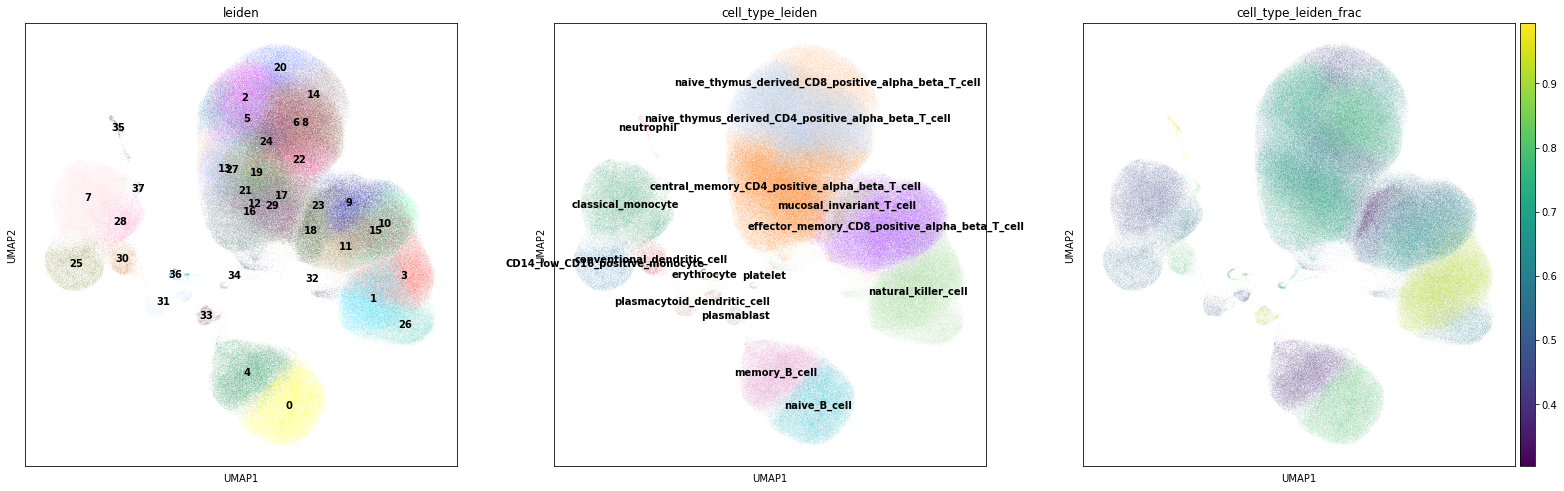

In [ ]:
with rc_context({'figure.figsize':[8,8]}):
    sc.pl.umap(adata, color=['leiden', 'cell_type_leiden', 'cell_type_leiden_frac'], legend_loc='on data')

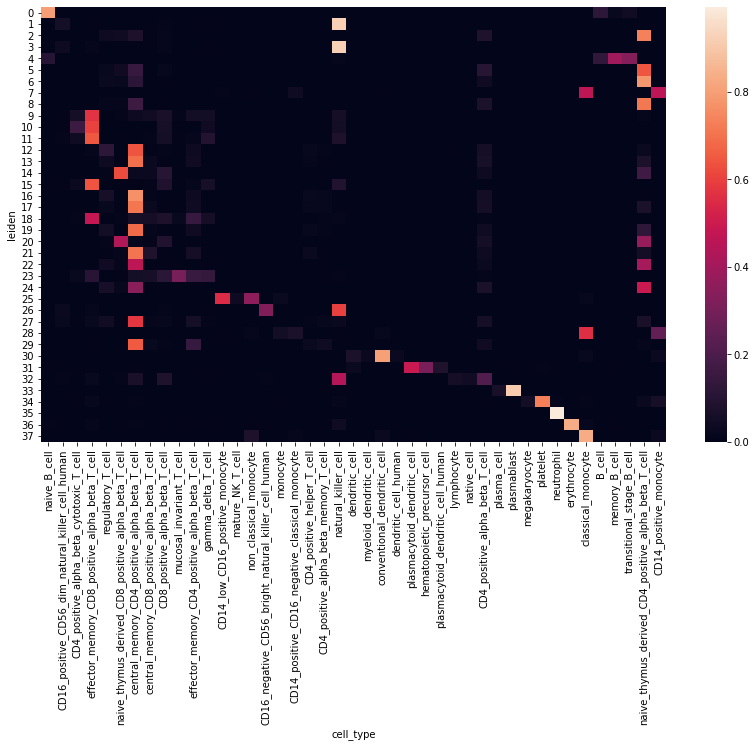

In [ ]:
conf_mat_plt = conf_mat.loc[:,conf_mat.max() > 0.025]
col_order = conf_mat_plt.idxmax(0).sort_values().index
with rc_context({'figure.figsize':[14,8]}):
    sns.heatmap(conf_mat_plt.loc[:,col_order])

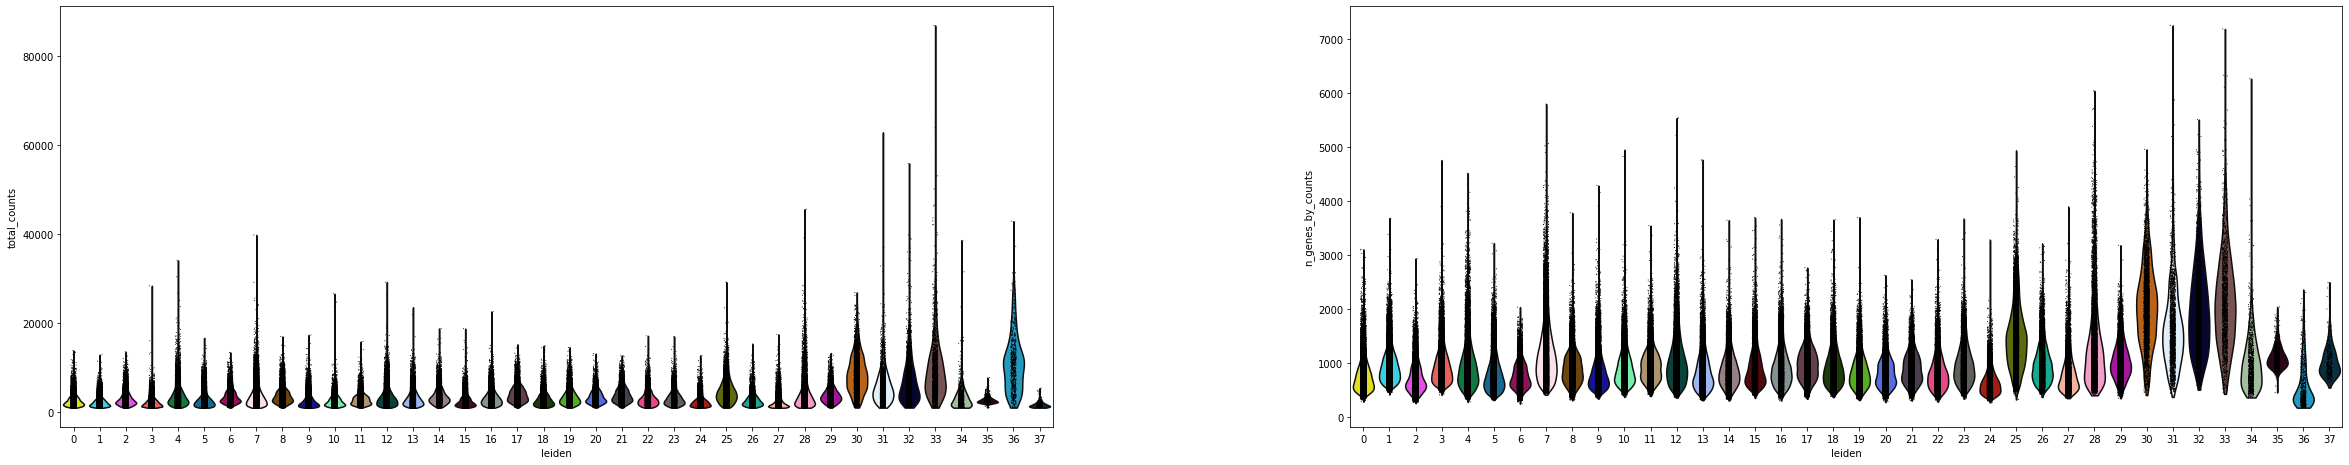

In [ ]:
with rc_context({'figure.figsize':[14,8]}):
    sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts'],groupby='leiden')

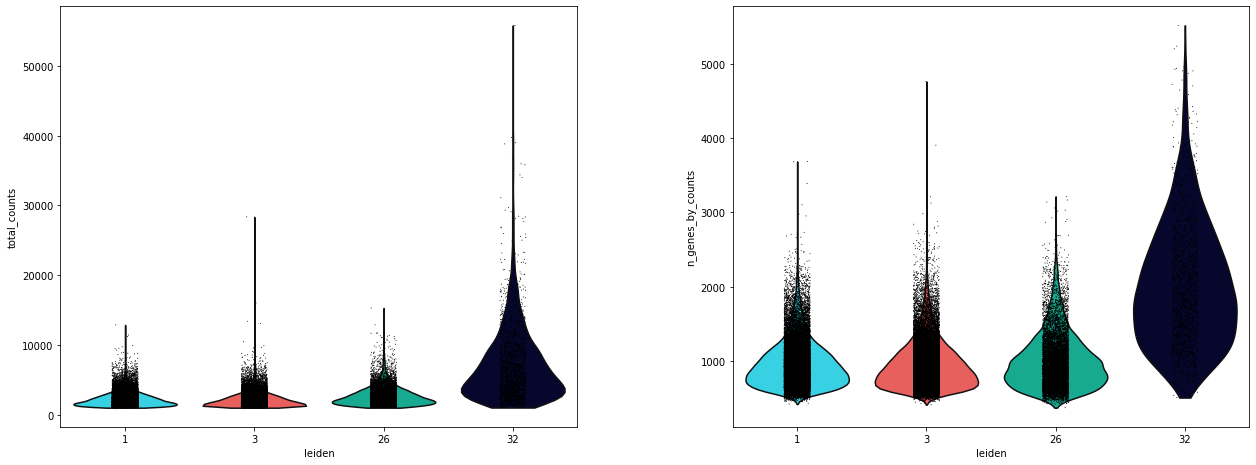

In [ ]:
with rc_context({'figure.figsize':[8,8]}):
    sc.pl.violin(adata[adata.obs['cell_type_leiden'] == 'natural_killer_cell'], ['total_counts', 'n_genes_by_counts'],groupby='leiden')
#     sc.pl.scatter(adata[adata.obs['cell_type_leiden'] == 'natural_killer_cell'], 'log1p_total_counts', 'n_genes_by_counts', color='leiden', groups='26', size=10)

In [ ]:
## Remove low-quality (potentially doublet) cluster
adata = adata[adata.obs['leiden'] != '32'].copy()

In [ ]:
## Make version with fixed names for submitting jobs 
def clean_pop_name(string):
    clean = ''.join(e if e.isalnum() else '_' for e in string)
    return('_'.join(clean.split('__')))

adata.obs['cell_type'] = [clean_pop_name(x) for x in adata.obs['cell_type_leiden']]

### Prep for jobs

In [ ]:
adata_full = sc.read_h5ad('/home/jovyan/mount/gdrive/query2reference/PBMC_CZIintegration_data/PBMC_merged.normal.subsample500cells.h5ad')

In [ ]:
adata_full

AnnData object with n_obs × n_vars = 634000 × 11724
    obs: 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type'
    var: 'gene_id', 'gene_name'

In [ ]:
adata_full = adata_full[adata.obs_names].copy()
adata_full.obs = adata.obs.copy()
adata_full.obsm = adata.obsm.copy()

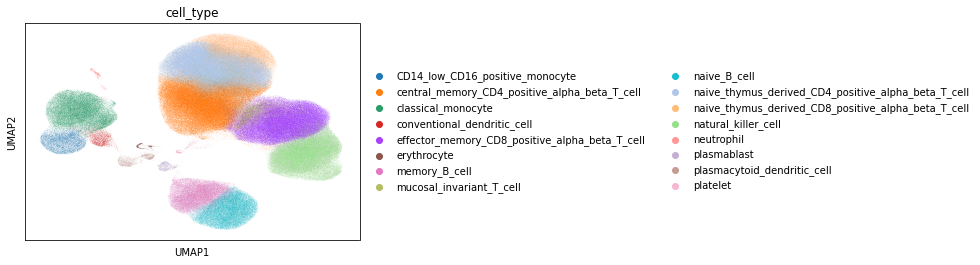

In [ ]:
sc.pl.umap(adata_full, color='cell_type')

In [ ]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
adata_full.write_h5ad(outdir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad')
outdir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad'

In [ ]:
## Save list of celltypes
with open(outdir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.txt', 'w') as f:
    for line in adata.obs['cell_type'].unique().tolist():
        f.write("%s\n" % line)

---